In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt
from math import sqrt 
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima_model import ARIMA
from itertools import product

In [2]:
sns.set_style("whitegrid")

In [3]:
# Upload the data
bitcoin = pd.read_csv('./Dataset/bitcoin.csv')

In [4]:
# Change the order of dates
bitcoin['Indx'] = np.arange(bitcoin.shape[0]-1, -1, -1)
bitcoin.set_index('Indx', inplace=True)
bitcoin.tail()

,Unnamed: 0,close,date,high,low,market_cap,open,volume
Indx,,,,,,,,
4,1863,105.21,"May 02, 2013",125.60,92.28,"1,292,190,000",116.38,-
3,1864,116.99,"May 01, 2013",139.89,107.72,"1,542,820,000",139.00,-
2,1865,139.00,"Apr 30, 2013",146.93,134.05,"1,597,780,000",144.00,-
1,1866,144.54,"Apr 29, 2013",147.49,134.00,"1,491,160,000",134.44,-
0,1867,134.21,"Apr 28, 2013",135.98,132.10,"1,500,520,000",135.30,-


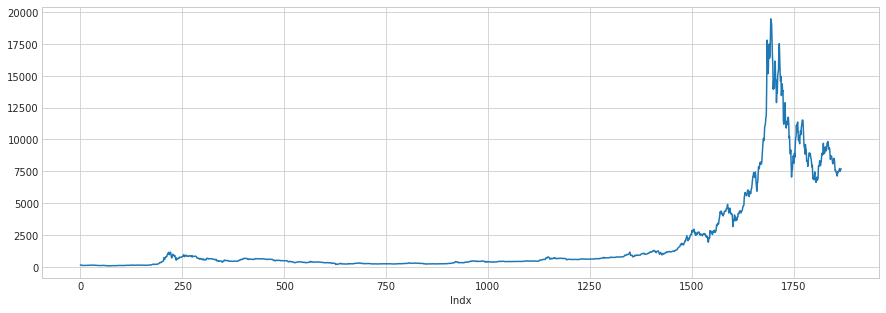

In [5]:
# Vizualisation
fig_size = [15, 5]
_ = bitcoin['open'].plot(figsize = fig_size)

In [6]:
# split the initial series to train adn test parts
bitcoin_series = pd.DataFrame(bitcoin.loc[::-1]['open'])

split_point = 1750
bitcoin_train = bitcoin_series.loc[:split_point, 'open']
bitcoin_test = bitcoin_series.loc[split_point:, 'open']

#### The criterium of the best model is the smallest value of rmse.

In [7]:
def count_error(test_set, predicted_set):
    
    rms = sqrt(mean_squared_error(test_set.values, predicted_set))
    
    return rms

## Exponential smoothing

In [8]:
def exponential_smoothing(train_set, test_set, smooth):
    
    exp_model = SimpleExpSmoothing(train_set.values).fit(smoothing_level=smooth, optimized=False)
    predict_values = exp_model.forecast(len(test_set))
    
    return predict_values, exp_model

def chose_best_param_exp_smoothing(train_set, test_set): # return smooth coefficient that minimize the error best

    smoothing_level_list = np.arange(0.1, 1, 0.1)

    model_pred_exp_sm = None
    error_exp_sm = None
    best_smooth_exp = 0

    for s in smoothing_level_list:
        exp_sm_values = exponential_smoothing(train_set, test_set, s)[0]
        error = count_error(test_set, exp_sm_values)
        if error_exp_sm is None:
            error_exp_sm = error
            model_pred_exp_sm = exp_sm_values
        else:
            if (error < error_exp_sm):
                error_exp_sm = error
                model_pred_exp_sm = exp_sm_values
                best_smooth_exp = s
    
    return best_smooth_exp

## Holt's model

In [9]:
def holts_model(train_set, test_set, smooth, slope):
    
    holt_model = Holt(train_set.values).fit(smoothing_level = smooth, smoothing_slope = slope)
    predict_values = holt_model.forecast(len(test_set))
    
    return predict_values, holt_model

def chose_best_param_holt(train_set, test_set):
    
    smoothing_level_list = np.arange(0.1, 1, 0.1)
    slope_list = np.arange(0.1, 1, 0.1)

    model_pred_holt = None
    error_holt = None
    best_smooth_holt = 0
    best_slope_holt = 0

    for s in smoothing_level_list:
        for slope in slope_list:
            holt_values = holts_model(train_set, test_set, s, slope)[0]
            error = count_error(test_set, holt_values)
            if error_holt is None:
                error_holt = error
                model_pred_holt = holt_values
            else:
                if (error < error_holt):
                    error_holt = error
                    model_pred_holt = holt_values
                    best_smooth_holt = s
                    best_slope_holt = slope
    
    return best_smooth_holt, best_slope_holt


## Holt-Winters method

<Figure size 864x576 with 0 Axes>

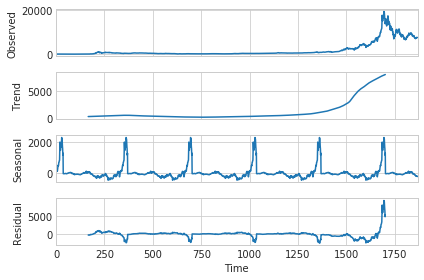

In [10]:
# explore season
import statsmodels.api as sm

plt.figure(figsize=[12, 8])
sm.tsa.seasonal_decompose(bitcoin_series.values, freq = 333).plot()
plt.show()

So, the value of season is 1 year (255 work days)

In [11]:
def h_w_model(train_set, test_set, season = 255):
    
    holt_winters_model = ExponentialSmoothing(train_set.values, trend='add', seasonal='add', seasonal_periods=season).fit()
    predict_values = holt_winters_model.forecast(len(test_set))
    
    return predict_values, holt_winters_model


## ARIMA model

In [12]:
bitcoin_series['first_diff'] = bitcoin_series['open'].diff()

The Dickey–Fuller test: p=0.371479


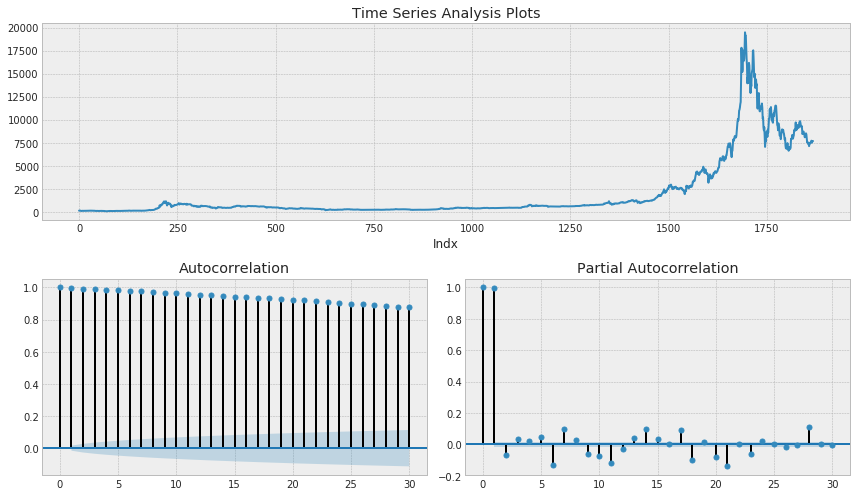

In [13]:
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 7), style = 'bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("The Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(bitcoin_series['open'], lags=30)

It can be seen that the series is unstationary. Let's count first differencies.

The Dickey–Fuller test: p=0.000000


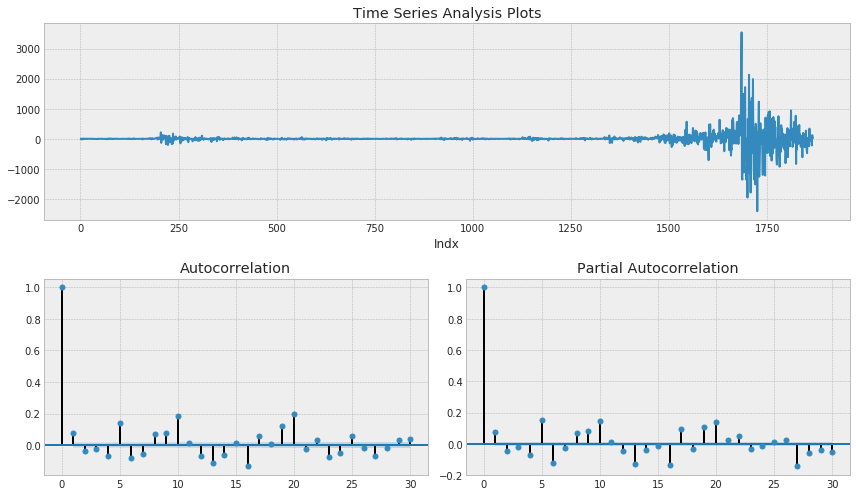

In [19]:
tsplot(bitcoin_series['first_diff'].dropna(), lags=30)

p-value = 0, so the series is stationary and diff_order for ARIMA model is 1.

In [14]:
# choose the parameters that minimize aic of the model

def chose_best_param_arima(series, diff_order = 1):
    
    # the ranges were chosen based on autocorrelation and partial autocorrelation functions
    q = np.arange(3, 6)
    p = np.arange(3, 6)
    parameters = product(q, p)
    parameters_list = list(parameters)

    results = []
    best_aic = float("inf")

    for param in parameters_list:
        try:
            model = ARIMA(series, order=(param[0],diff_order,param[1]))
            model_fit = model.fit(disp=0)
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model_fit.aic
        
        if aic < best_aic:
            best_model = model_fit
            best_aic = aic
            best_param = param
    results.append([best_param, best_aic])

    return results


## GARCH

In [15]:
from arch import arch_model

In [16]:
# choose the parameters that minimize aic of the model

def chose_best_param_garch(series, diff_order = 1):
    
    q = np.arange(3, 6)
    p = np.arange(3, 6)
    parameters = product(q, p)
    parameters_list = list(parameters)

    results = []
    best_aic = float("inf")

    for param in parameters_list:
        try:
            model = arch_model(series, p=param[0], o=1, q=param[1])
            model_fit = model.fit(update_freq=5, disp='off')
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model_fit.aic
        
        if aic < best_aic:
            best_model = model_fit
            best_aic = aic
            best_param = param
    results.append([best_param, best_aic])

    return results


In [17]:
# fit all model with the best parameters on train set, count errors on train set,
# based on the errors choose the best model and predict values for the preset period 

def get_prediction_best_model(train_set, test_set, period):
    
    print('exp')
    # exponential smoothing
    smooth_value_exp = chose_best_param_exp_smoothing(train_set, test_set)
    # fit model with found params
    pred_val_exp, model_exp = exponential_smoothing(train_set, test_set, smooth_value_exp)
    # count the error of model on test set
    error_exp = count_error(test_set, pred_val_exp)
    
    print('holt')
    # Holt's method
    smooth_value_holt, slope_value_holt = chose_best_param_holt(train_set, test_set)
    # fit the model with found params
    pred_val_holt, model_holt = holts_model(train_set, test_set, smooth_value_holt, slope_value_holt)
    # count the error of model on test set
    error_holt = count_error(test_set, pred_val_holt)
    
    print('holt_winters')
    # Holt-Winters model
    pred_val_holt_winters, model_holt_winters = h_w_model(train_set, test_set)
    # count the error of model on test set
    error_holt_winters = count_error(test_set, pred_val_holt_winters)
    
    print('ARIMA')
    # ARIMA model
    ARIMA_params = chose_best_param_arima(train_set)[0][0]
    # fit model with found params
    model_ARIMA = ARIMA(train_set, order=(ARIMA_params[0], 1, ARIMA_params[1])).fit(disp=0)
    pred_val_ARIMA = model_ARIMA.forecast(len(test_set))[0]
    # count the error of model on test set
    error_ARIMA = count_error(test_set, pred_val_ARIMA)
    
    print('GARCH')
    # GARCH model
    GARCH_params = chose_best_param_garch(train_set)[0][0]
    # fit model with found params
    model_GARCH = arch_model(train_set, p=GARCH_params[0], o=1, q=GARCH_params[1]).fit(disp='off')
    forecasts = model_GARCH.forecast(horizon=len(test_set))
    pred_val_GARCH = forecasts.mean.iloc[len(train_set)-1,:].values
    # count the error of model on test set
    error_GARCH = count_error(test_set, pred_val_GARCH)

    
    if (error_exp == min([error_exp, error_holt, error_holt_winters, error_ARIMA, error_GARCH])):
        predicted_values = model_exp.forecast(period)
        model_name = 'Exponential smoothing'
    if (error_holt == min([error_exp, error_holt, error_holt_winters, error_ARIMA, error_GARCH])):
        predicted_values = model_holt.forecast(period)
        model_name = 'Holts method'
    if (error_holt_winters == min([error_exp, error_holt, error_holt_winters, error_ARIMA, error_GARCH])):
        predicted_values = model_holt_winters.forecast(period)
        model_name = 'Holt-Winters method'
    if (error_ARIMA == min([error_exp, error_holt, error_holt_winters, error_ARIMA, error_GARCH])):
        predicted_values = model_ARIMA.forecast(period)
        model_name = 'ARIMA model'
    if (error_GARCH == min([error_exp, error_holt, error_holt_winters, error_ARIMA, error_GARCH])):
        predicted_values = model_GARCH.forecast(horizont = period).mean.iloc[len(train_set)-1,:].values
        model_name = 'GARCH model'
    
    return predicted_values, model_name
    

exp
holt
holt_winters
ARIMA
GARCH


/home/khrystyna/.local/lib/python3.5/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/home/khrystyna/.local/lib/python3.5/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/home/khrystyna/.local/lib/python3.5/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/home/khrystyna/.local/lib/python3.5/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


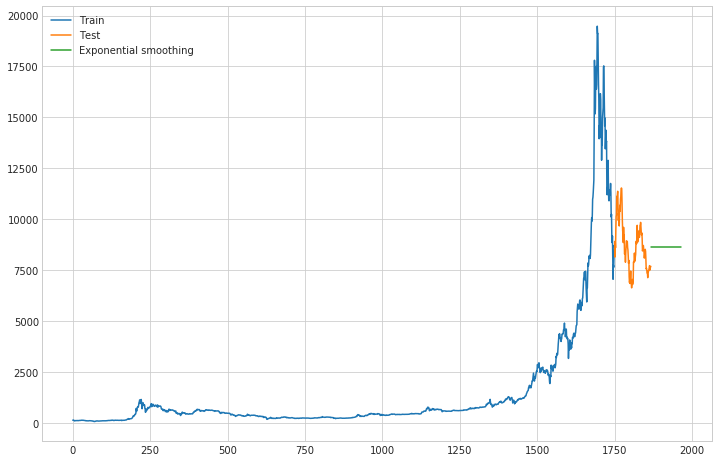

In [18]:
prediction_period = 100
values, name = get_prediction_best_model(bitcoin_train, bitcoin_test, prediction_period)
indx_pred = np.arange(bitcoin_test.index[-1], bitcoin_test.index[-1] + prediction_period)

# visualisation
plt.figure(figsize=[12, 8])
plt.plot(bitcoin_train.index, bitcoin_train.values, label='Train')
plt.plot(bitcoin_test.index, bitcoin_test.values, label='Test')
plt.plot(indx_pred, values, label=name)
plt.legend(loc='best')
plt.show()

The simple exponential smoothing approach provides the best result.